# 1. Map Visualizations 

Here I will write some functions that will make visualizations easy on a "heat-map" of the United States.

## 1.1 Wheat Production by State

### Setup and Plotting code

In [1]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

In [2]:
#this mapping between states and abbreviations will come in handy later
states_abbrev = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

Code to plot State Chloropleth maps in matplotlib. "make_map" is the function actually used to create the maps.

In [3]:
#adapted from  https://github.com/dataiap/dataiap/blob/master/resources/util/map_util.py

#load in state geometry
state2poly = defaultdict(list)

data = json.load(file("data/us-states.json"))
for f in data['features']:
    state = states_abbrev[f['id']]
    geo = f['geometry']
    if geo['type'] == 'Polygon':
        for coords in geo['coordinates']:
            state2poly[state].append(coords)
    elif geo['type'] == 'MultiPolygon':
        for polygon in geo['coordinates']:
            state2poly[state].extend(polygon)

            
def draw_state(plot, stateid, **kwargs):
    """
    draw_state(plot, stateid, color=..., **kwargs)
    
    Automatically draws a filled shape representing the state in
    subplot.
    The color keyword argument specifies the fill color.  It accepts keyword
    arguments that plot() accepts
    """
    for polygon in state2poly[stateid]:
        xs, ys = zip(*polygon)
        plot.fill(xs, ys, **kwargs)

        
def make_map(states, label):
    """
    Draw a cloropleth map, that maps data onto the United States
    
    Inputs
    -------
    states : Column of a DataFrame
        The value for each state, to display on a map
    label : str
        Label of the color bar

    Returns
    --------
    The map
    """
    fig = plt.figure(figsize=(12, 9))
    ax = plt.gca()

    if states.max() < 2: # colormap for election probabilities 
        cmap = cm.RdBu
        vmin, vmax = 0, 1
    else:  # colormap for electoral votes
        cmap = cm.binary
        vmin, vmax = 0, states.max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    skip = set(['National', 'District of Columbia', 'Guam', 'Puerto Rico',
                'Virgin Islands', 'American Samoa', 'Northern Mariana Islands'])
    for state in states_abbrev.values():
        if state in skip:
            continue
        if state not in states:
            continue
        color = cmap(norm(states.ix[state]))
        draw_state(ax, state, color = color, ec='k')

    #add an inset colorbar
    ax1 = fig.add_axes([0.45, 0.70, 0.4, 0.02])    
    cb1=mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                  norm=norm,
                                  orientation='horizontal')
    ax1.set_title(label)
    remove_border(ax, left=False, bottom=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-180, -60)
    ax.set_ylim(15, 75)
    return ax

In [4]:
wheat_production_by_state=pd.read_csv("state_wheat_production_by_year.csv")

In [5]:
#change the states to lowercase except first letter 
wheat_production_by_state['State'] = wheat_production_by_state['State'].map(lambda x: x.title())
#remove the commas from the production values and change the production values to floats 
wheat_production_by_state['Value'] = wheat_production_by_state['Value'].map(lambda x: float(x.replace(',','')))
wheat_production_by_state.head(3)

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,SURVEY,2015,YEAR,NaN,STATE,Alabama,1,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,WHEAT,"WHEAT - PRODUCTION, MEASURED IN BU",TOTAL,NOT SPECIFIED,14960000,NaN
1,SURVEY,2015,YEAR,NaN,STATE,Arizona,4,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,WHEAT,"WHEAT - PRODUCTION, MEASURED IN BU",TOTAL,NOT SPECIFIED,14346000,NaN
2,SURVEY,2015,YEAR,NaN,STATE,Arkansas,5,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,WHEAT,"WHEAT - PRODUCTION, MEASURED IN BU",TOTAL,NOT SPECIFIED,13440000,NaN


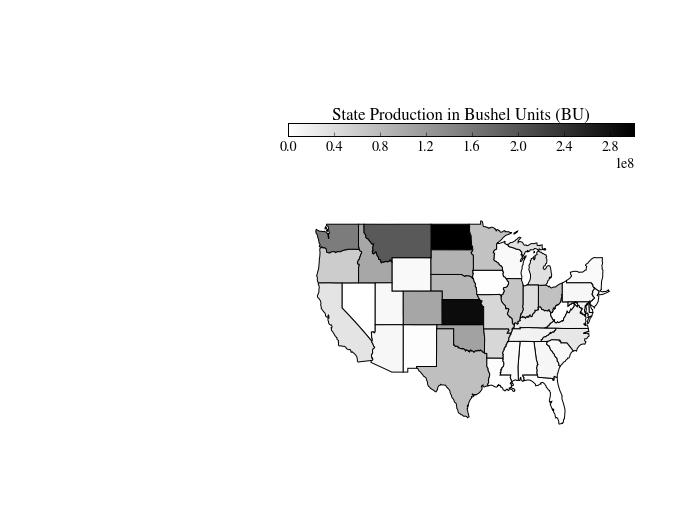

In [89]:
make_map(wheat_production_by_state.loc[wheat_production_by_state['Year'] == 1995].set_index('State').Value,"State Production in Bushel Units (BU)")

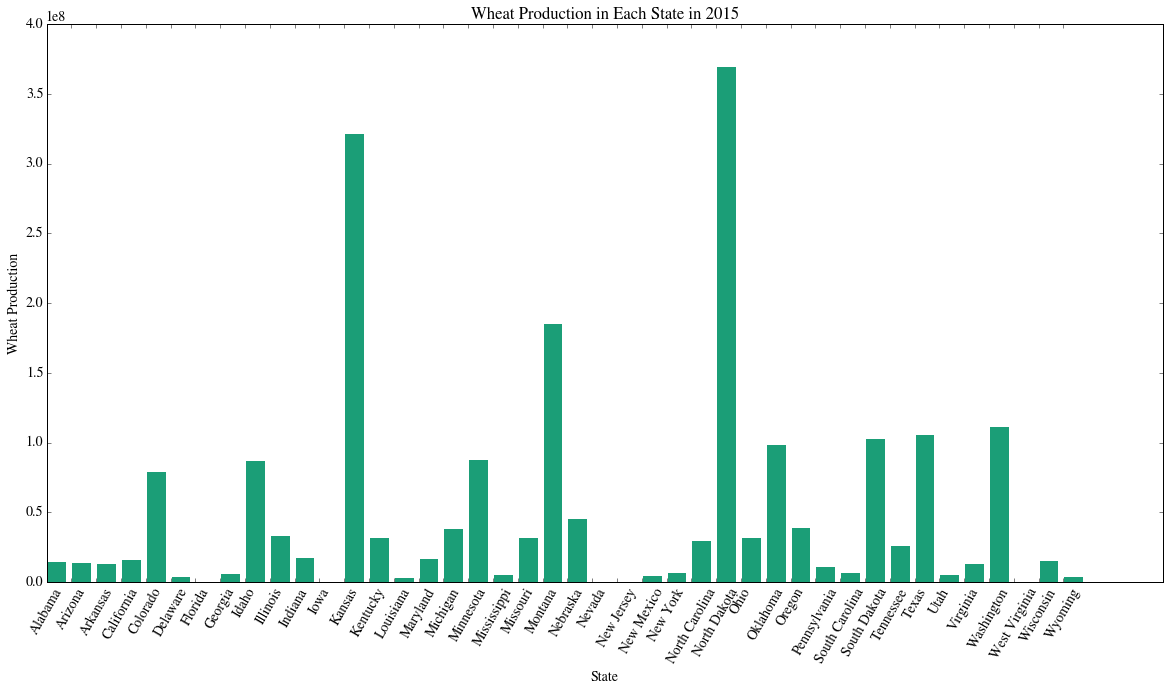

In [78]:
wheat_2015 = wheat_production_by_state[wheat_production_by_state['Year'] == 2015]
plt.figure(figsize=(20,10))
plt.bar(wheat_2015.index, wheat_2015.Value)
plt.xticks(wheat_2015.index, wheat_2015.State, rotation=60)
plt.xlabel('State')
plt.ylabel('Wheat Production')
plt.title('Wheat Production in Each State in 2015')

## 1.2 Precipitation 

In [8]:
prec = pd.read_csv("precdf.csv")

In [9]:
prec.head(10)

,State,Year,Jan,Feb,March,April,May,June,July,August,September,October,November,December
0,AS,1981,42.79,37.45,107.62,60.67,40.96,36.06,62.03,52.92,30.92,68.66,71.63,78.66
1,AS,1982,50.39,96.43,32.11,20.16,33.55,28.27,31.99,93.56,41.50,64.18,39.65,15.95
2,AS,1983,33.51,29.71,30.44,26.42,16.44,17.17,10.20,17.88,34.33,68.01,25.31,72.42
3,AS,1984,33.68,35.38,81.87,27.15,29.16,32.88,12.46,33.91,29.32,65.78,47.87,97.87
4,AS,1985,52.02,30.78,32.79,84.14,28.84,47.87,34.47,31.93,52.96,54.10,39.50,16.51
5,AS,1986,85.73,42.12,27.99,70.95,50.12,31.35,38.78,29.89,63.68,47.40,43.12,83.10
6,AS,1987,51.46,76.48,39.54,35.73,31.18,27.88,20.43,34.98,8.41,26.69,22.98,62.08
7,AS,1988,33.36,47.98,49.08,44.00,42.97,28.17,38.78,25.48,37.92,46.45,59.69,89.15
8,AS,1989,55.23,58.06,32.73,53.88,36.72,30.79,41.66,2.09,7.88,49.82,63.79,37.31
9,AS,1990,49.32,68.57,32.88,45.18,16.35,35.98,22.14,15.41,26.11,54.39,45.25,35.30


In [22]:
#prec_new = prec.groupby(['State','Year'])
prec_grouped = prec.groupby(['State','Year']).mean().reset_index()
prec_grouped.head()

,State,Year,Jan,Feb,March,April,May,June,July,August,September,October,November,December
0,AK,1981,15.683362,8.257069,8.708879,3.853276,4.915259,6.550172,10.535862,15.486552,12.651207,12.820948,12.226121,7.486121
1,AK,1982,5.100342,3.618462,5.281624,5.847863,6.187179,5.819829,7.964359,6.752137,15.152222,11.733419,9.297863,9.896068
2,AK,1983,7.984655,6.574655,2.432241,7.119828,6.262931,4.087155,6.538879,13.819310,10.171466,13.382414,8.525172,3.358017
3,AK,1984,12.432069,8.805259,6.767759,5.168362,4.187759,6.101121,8.322500,10.346638,8.663448,9.372586,7.268966,10.093190
4,AK,1985,15.284348,7.119652,8.681217,5.548087,5.936609,7.537130,5.375565,10.198435,13.984087,9.077913,4.656261,15.266783


In [79]:
#remove non 50 state entries such as Puerto Rico from prec_grouped
for col in prec_grouped:
    if (col=='State'):
        prec_grouped= prec_grouped[(prec_grouped[col] != 'FM') & (prec_grouped[col] != 'UM')
                                   & (prec_grouped[col] != 'MH') & (prec_grouped[col] != 'PW')]

In [80]:
def make_map_prec(year, start_month, end_month): 
    input_df = prec_grouped.loc[prec_grouped['Year'] == year]
    input_df['cumulative_rainfall'] = (prec_grouped.ix[:,start_month:end_month]).sum(axis=1)
    for index, row in input_df.iterrows():
        state_full=states_abbrev[row['State']]
        input_df['State'][index]=state_full
    make_map(input_df.set_index('State').cumulative_rainfall,"Total Rainfall in Inches by State from "+str(start_month)+" to "+str(end_month)+" "+str(year))

C:\Users\Vinh\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Vinh\Anaconda\lib\site-packages\IPython\kernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Vinh\Anaconda\lib\site-packages\IPython\kernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


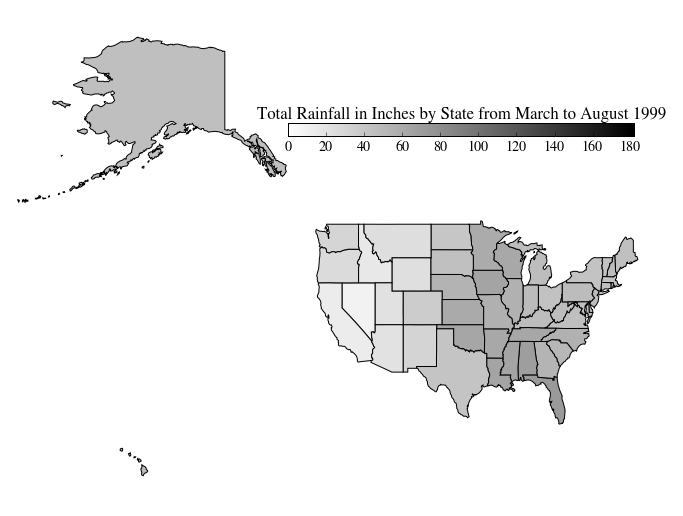

In [81]:
make_map_prec(1999,'March','August')

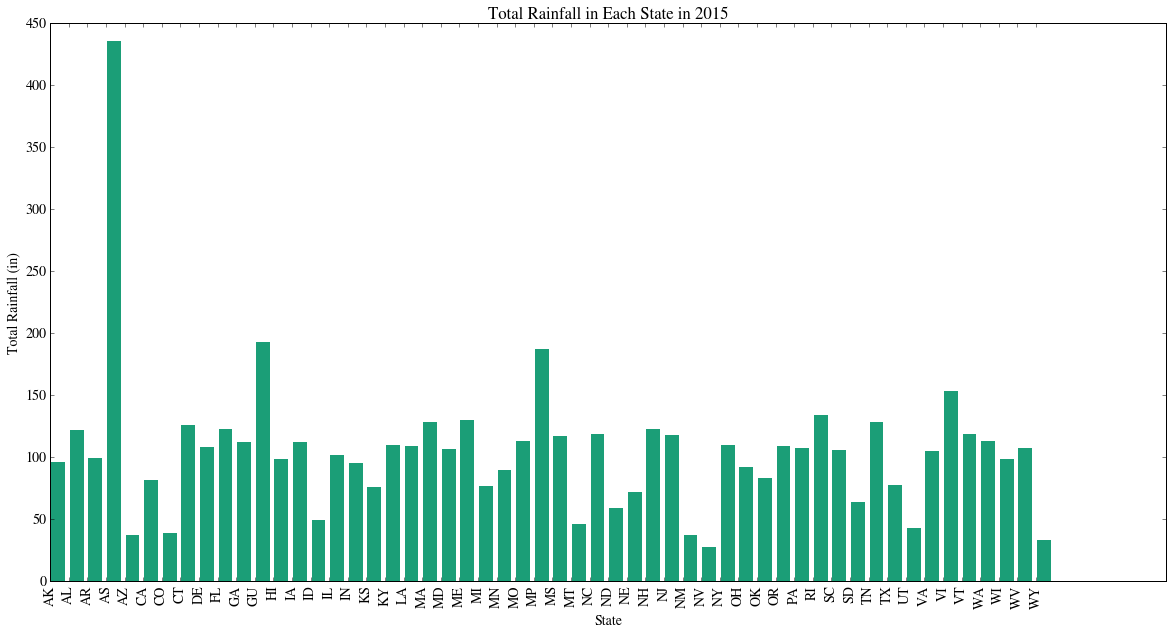

In [75]:
prec_2010 = prec_grouped[prec_grouped['Year'] == 2010].reset_index()
prec_2010['Total']=(prec_2010.ix[:,"Jan":'December']).sum(axis=1)
plt.figure(figsize=(20,10))
plt.bar(prec_2010.index, prec_2010.Total)
plt.xticks(prec_2010.index, prec_2010.State, rotation=90)
plt.xlabel('State')
plt.ylabel('Total Rainfall (in)')
plt.title('Total Rainfall in Each State in 2015')

In [44]:
temp=pd.read_csv("tempdf.csv")

In [45]:
temp.columns=['State','Year','January','February','March','April','May','June','July','August','September','October','November','December']
temp.head()

,State,Year,January,February,March,April,May,June,July,August,September,October,November,December
0,AK,1981,-7.316923,-10.849936,-2.146795,-0.466090,7.246795,11.301154,12.566090,11.463397,6.910577,-0.061474,-7.999615,-11.240769
1,AK,1982,-10.096667,-12.740577,-6.355897,-3.707115,4.874872,10.444679,13.082628,11.590128,7.221410,-3.105769,-10.229295,-7.180000
2,AK,1983,-10.949359,-9.052115,-6.856731,-1.559167,6.256795,11.532115,13.462115,11.002885,6.548077,-0.134551,-6.825641,-8.156731
3,AK,1984,-9.910449,-10.662051,-4.902692,-0.588718,6.524423,11.626667,13.034487,11.729359,7.952244,1.275385,-7.563333,-10.658910
4,AK,1985,-7.611731,-10.805769,-4.969167,-1.978077,6.095833,10.585897,13.630897,11.520577,6.658910,-2.034872,-10.239231,-7.453141


In [50]:
#remove non 50 state entries such as PR from prec_grouped
for col in temp:
    if (col=='State'):
        temp=temp[(temp[col] != 'FM') & (temp[col] != 'PR') & (temp[col] != 'UM') & (temp[col] != 'MH') & (temp[col] != 'PW')]

In [51]:
def make_map_temp(year, start_month, end_month): 
    input_df = temp.loc[temp['Year'] == year]
    input_df['mean_temp'] = (temp.ix[:,start_month:end_month]).mean(axis=1)
    for index, row in input_df.iterrows():
        state_full=states_abbrev[row['State']]
        input_df['State'][index]=state_full
    make_map(input_df.set_index('State').mean_temp,"Mean Temperature by State in Celsius from "+str(start_month)+" to "+str(end_month)+" "+str(year))

C:\Users\Vinh\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Vinh\Anaconda\lib\site-packages\IPython\kernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Vinh\Anaconda\lib\site-packages\IPython\kernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


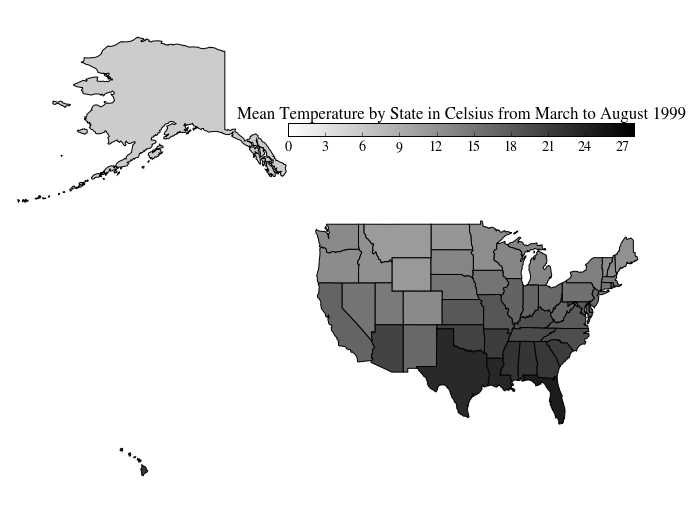

In [52]:
make_map_temp(1999,'March','August')

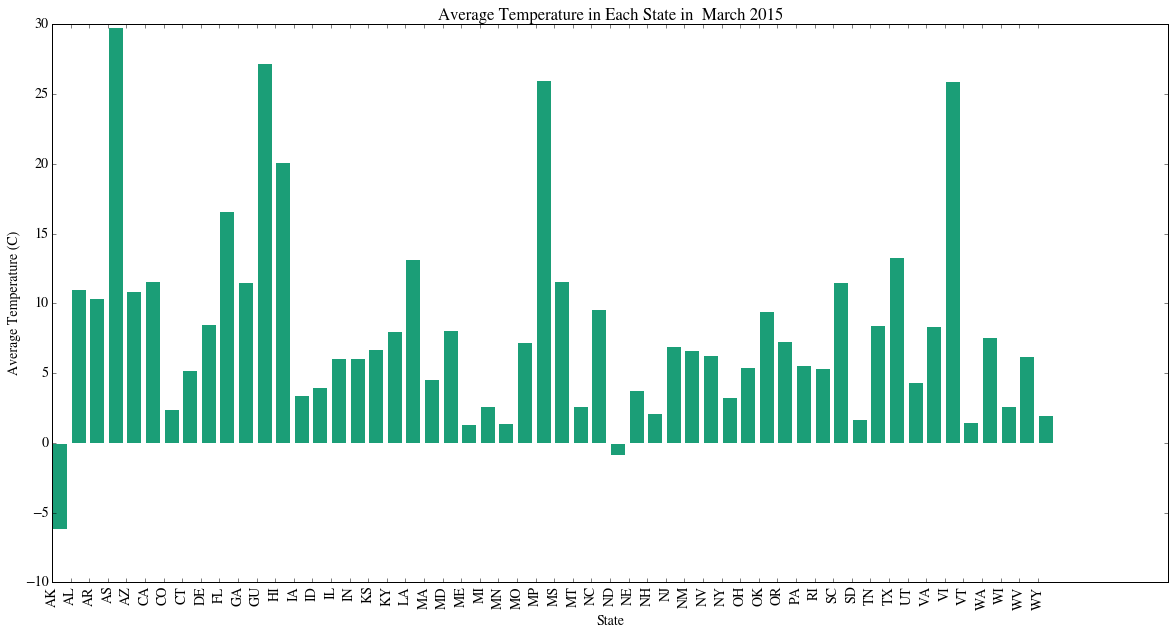

In [77]:
temp_2010 = temp[temp['Year'] == 2010].reset_index()
temp_2010['Total']=(temp_2010.ix[:,"March":'March']).mean(axis=1)
plt.figure(figsize=(20,10))
plt.bar(temp_2010.index, temp_2010.Total)
plt.xticks(temp_2010.index, temp_2010.State, rotation=90)
plt.xlabel('State')
plt.ylabel('Average Temperature (C)')
plt.title('Average Temperature in Each State in  March 2015')